* Calculate explained/attributable polarization from activity data

In [2]:
partisan_dimen = "partisan"

In [3]:
import sys
import os
sys.path.append("..")
from commembed.jupyter import *
import commembed.linalg as linalg
import commembed.dimens as dimens
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from pyspark.sql.functions import *

import commembed.data as data
import commembed.analysis as analysis


spark = data.spark_context()

%load_ext autoreload
%autoreload 2

In /u/walleris/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /u/walleris/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /u/walleris/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /u/walleris/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /u/walleris/miniconda3/lib/python3.7/site-packages/matplo

Spark WebUI: http://ada.ais.sandbox:4048
Spark WebUI: http://ada.ais.sandbox:4048


In [ ]:
activity_data = data.load(f"{partisan_dimen}_activity_data_12mo")

scores_dfs = []
for cat in ["all","left","right"]:
    df, _ = load_abs_z_df(partisan_dimen, political_activity_category=cat)
    df["category"] = cat
    scores_dfs.append(df.reset_index())
    
scores = pd.concat(scores_dfs)
scores_df = spark.createDataFrame(scores.reset_index())
scores_df.createOrReplaceTempView("scores")

In [5]:
agg_activity = activity_data.join(scores_df, scores_df["community"] == activity_data["subreddit"])
agg_activity = agg_activity.groupBy(["category", "month", (col("last_month_user_bin") == 5).alias("is_new")]).agg(
    sum(col("partisan_dimen") * col("num_comments")).alias("abs_z_sum"), sum(col("num_comments")).alias("num_comments"))

agg_activity = agg_activity.toPandas()
agg_activity.head(5)

,category,month,is_new,abs_z_sum,num_comments
0,all,2016-04,False,6.672315e+06,4359667
1,left,2016-05,True,1.574264e+06,944591
2,left,2012-08,False,5.538132e+05,431489
3,all,2013-12,False,1.738040e+06,1495170
4,all,2018-02,False,9.404917e+06,6327787


In [46]:
import seaborn as sns

def calculate_explained_polarization(category, agg_by_year=True):
    
    to_plot = agg_activity[agg_activity["category"] == category].drop(columns=['category'])
    
    agg_by_year = True
    if agg_by_year:
        to_plot["year"] = to_plot["month"].str.slice(0,4)
        to_plot = to_plot.groupby(['year', 'is_new']).agg('sum')
        to_plot = to_plot.reset_index().rename(columns={"year": "month"})

    months = sorted(to_plot["month"].unique())

    to_plot = to_plot.set_index(["month", "is_new"])
    

    result = []
    stride = 1 if agg_by_year else 12
    for last_month, month in zip(months[:-stride], months[stride:]):

        total_comments = (to_plot.loc[(month, True), "num_comments"] + to_plot.loc[(month, False), "num_comments"])

        actual = (to_plot.loc[(month, True), "abs_z_sum"] + to_plot.loc[(month, False), "abs_z_sum"]) / \
            total_comments

        last_actual = (to_plot.loc[(last_month, True), "abs_z_sum"] + to_plot.loc[(last_month, False), "abs_z_sum"]) / \
            (to_plot.loc[(last_month, True), "num_comments"] + to_plot.loc[(last_month, False), "num_comments"])

        # change in polarization between new this month and overall last month
        change_for_new = (to_plot.loc[(month, True), "abs_z_sum"] / to_plot.loc[(month, True), "num_comments"]) - \
            last_actual
        
        # change in polarization between old this month and overall last month
        change_for_old = (to_plot.loc[(month, False), "abs_z_sum"] / to_plot.loc[(month, False), "num_comments"]) - \
            last_actual

        static_old = ((to_plot.loc[(month, True), "num_comments"]) / total_comments) * change_for_new
        static_new = ((to_plot.loc[(month, False), "num_comments"]) / total_comments) * change_for_old

        result.append({
            "month": month,
            "total_comments": total_comments,
            "proportion_new": to_plot.loc[(month, True), "num_comments"]/total_comments,

            "actual": (actual-last_actual),
            "static_new": (static_new),
            "static_old": (static_old),
            "sum":(static_new)+(static_old)
        })
    
    
    result = pd.DataFrame(result)
    result["year"] = result["month"].str.slice(0,4)

    result = result.set_index("month").sort_index(axis=1)
    
    if agg_by_year:
        result.index.name = "year"
        
    return result

for cat in ["all","left","right"]:
    result = calculate_explained_polarization(cat)
    result.to_csv(os.path.join(data.DATA_PATH, "explained_polarization_%s_%s.csv" % (partisan_dimen, cat)), index=True)

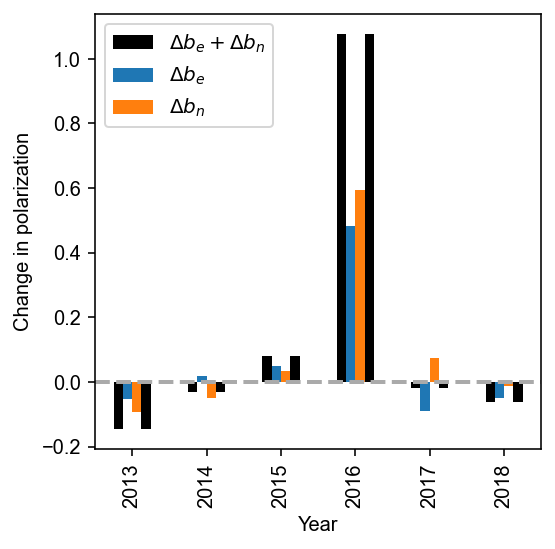

/u/walleris/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


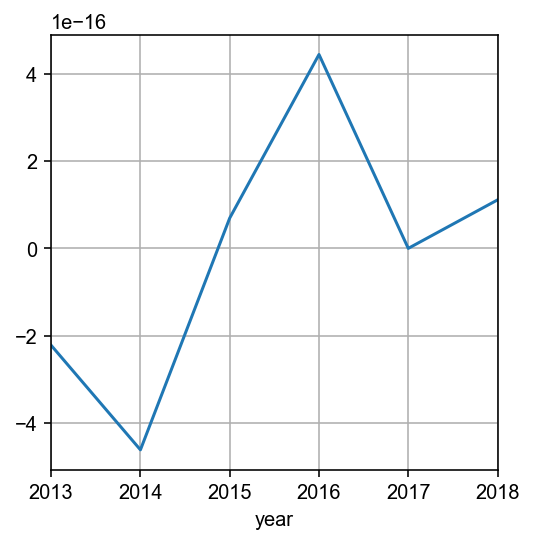

In [45]:
result = calculate_explained_polarization("right", agg_by_year=True)

plt.figure(figsize=(4,4))
ax = plt.gca()
ax.axhline(0, linewidth=2, linestyle='--', color='#aaaaaa', label='_nolegend_')

colors = sns.color_palette()
result[['actual','static_new','static_old', 'sum']].plot.bar(figsize=(4,4), color=['black']+colors[:2], ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Change in polarization")
ax.legend([
    "$\Delta b_e + \Delta b_n$",
    "$\Delta b_e$",
    "$\Delta b_n$"
])
#plt.savefig('draft-explained-polarization.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
(result['actual']-result['sum']).plot.line()
plt.grid()

In [8]:
result

,total_comments,proportion_new,actual,static_new,static_old,sum
year,,,,,,
2013,6807690.0,5.802141,-0.140136,-0.055526,-0.083708,-0.139234
2014,9728412.0,5.367151,-0.029454,-0.003849,-0.023217,-0.027066
2015,13569936.0,5.099656,0.090799,0.016443,0.075934,0.092377
2016,24009667.0,5.290774,1.071138,0.477917,0.592358,1.070275
2017,29003214.0,5.077053,0.074072,0.041510,0.019586,0.061097
2018,26210318.0,4.081147,-0.053897,0.014252,-0.097195,-0.082944
